In [1]:
import tensorflow as tf
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2024-06-10 19:26:40.756674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 19:26:41.294780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


2024-06-10 19:26:41.945420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:26:41.973025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:26:41.973072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Load cifar dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
# Normalization
#x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
# Convert the label into the categorical crossentropy

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
num_classes = 50
input_shape = (32, 32, 3)

# ViT Base
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 12
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12
mlp_head_units = [
    3072,
]

In [7]:
from modules.vision_transformers.patches import Patches
from modules.vision_transformers.patch_encoder import PatchEncoder, mlp

In [8]:
# Data Augmentation for resize
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Resizing(image_size, image_size)
])

# Compute the average and variance of the training data for normalization purpose
data_augmentation.layers[0].adapt(x_train)

2024-06-10 19:26:42.497183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:26:42.497280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:26:42.497309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:26:43.330726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:26:43.330787: I external/local_xla/xla/stream_executor

In [9]:
# Define the model
def create_classifier():
    inputs = tf.keras.Input(shape=input_shape)

    # Apply augment resize
    augmented = data_augmentation(inputs)
    
    # Create Patches
    patches = Patches(patch_size)(augmented)

    # Encode every patches position
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        # Create multilayers about how many transformers layer needed
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
        # Create a multi-head attention layer
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # layer normalization 2
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)

        # NLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip Connection
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [10]:
model = create_classifier()

In [12]:
total_steps = len(x_train) * num_epochs
decay_steps = total_steps * 0.3
# Cosine Learning Rate Decay
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    alpha=0.1,
    warmup_steps=10000
)

In [13]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=cosine_decay_scheduler),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name='top-5-accuracy')
    ]
)

In [14]:
history = model.fit(
    x=x_train,
    y=y_train_categorical,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(x_test, y_test_categorical)
)

Epoch 1/10


I0000 00:00:1718015249.680735  364230 service.cc:145] XLA service 0x7f409c002d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718015249.680777  364230 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-06-10 19:27:30.566078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-10 19:27:34.546010: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1718015282.374945  364288 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_503', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1718015282.766621  364296 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_600', 304 bytes spill stores, 292 bytes spill loads

I0000 0

1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3020 - loss: 2.5463 - top-5-accuracy: 0.7915

I0000 00:00:1718015406.254109  364489 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_503', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1718015435.480253  364230 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'copy_fusion', 36 bytes spill stores, 36 bytes spill loads



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3021 - loss: 2.5454 - top-5-accuracy: 0.7916

I0000 00:00:1718015438.002338  364611 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_163', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1718015438.175845  364603 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_163', 436 bytes spill stores, 380 bytes spill loads

I0000 00:00:1718015438.520112  364601 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_163', 1156 bytes spill stores, 1144 bytes spill loads



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 218s 80ms/step - accuracy: 0.3022 - loss: 2.5450 - top-5-accuracy: 0.7916 - val_accuracy: 0.4806 - val_loss: 1.4286 - val_top-5-accuracy: 0.9227
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.4645 - loss: 1.4913 - top-5-accuracy: 0.9099 - val_accuracy: 0.4968 - val_loss: 1.3905 - val_top-5-accuracy: 0.9249
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.4593 - loss: 1.5166 - top-5-accuracy: 0.9049 - val_accuracy: 0.4907 - val_loss: 1.4364 - val_top-5-accuracy: 0.9197
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.4305 - loss: 1.5997 - top-5-accuracy: 0.8919 - val_accuracy: 0.4528 - val_loss: 1.5318 - val_top-5-accuracy: 0.9033
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.4248 - loss: 1.6250 - top-5-accuracy: 0.8902 - val_accuracy: 0.4540 - val_loss: 1.5401 - val_top-5-accuracy: 0.9079
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.4469 - los

In [16]:
history.history

{'accuracy': [0.3619399964809418,
  0.47398000955581665,
  0.4487200081348419,
  0.4147399961948395,
  0.4117799997329712,
  0.46136000752449036,
  0.5204399824142456,
  0.5719199776649475,
  0.6312199831008911,
  0.6993600130081177],
 'loss': [1.8947107791900635,
  1.4732693433761597,
  1.5491605997085571,
  1.6448572874069214,
  1.6453603506088257,
  1.5054134130477905,
  1.3497945070266724,
  1.203768014907837,
  1.045919418334961,
  0.8579182028770447],
 'top-5-accuracy': [0.844219982624054,
  0.9125800132751465,
  0.8995400071144104,
  0.8834199905395508,
  0.8847200274467468,
  0.9095799922943115,
  0.9313399791717529,
  0.9506199955940247,
  0.9653400182723999,
  0.9793400168418884],
 'val_accuracy': [0.4805999994277954,
  0.4968000054359436,
  0.49070000648498535,
  0.4528000056743622,
  0.45399999618530273,
  0.510200023651123,
  0.5404000282287598,
  0.5842000246047974,
  0.5968000292778015,
  0.6175000071525574],
 'val_loss': [1.4286177158355713,
  1.3905454874038696,
  1.43

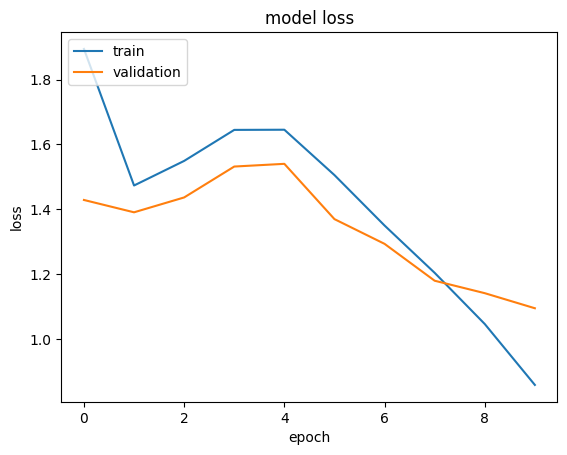

In [18]:
import matplotlib.pyplot as plt

# Save Train result
fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

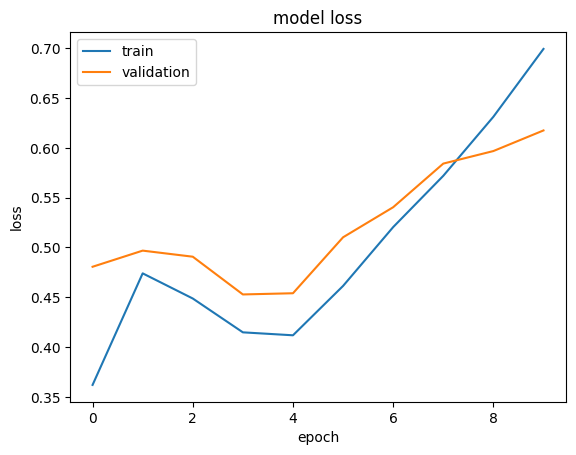

In [19]:
# Save Train result
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()